Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
path= "../"
import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
import copy
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import pickle
import utils
import os
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use(f'article.mplstyle')

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
category = "imbalanced_data"

In [3]:
all_df = None
for run in range(3):
    for name in [f"{path}output/pickle_results/{category}/{category}_run_{run}.pkl"]:
        df = pd.read_pickle(name)
        df["run"] = run
        if all_df is None:
            all_df = df
        else:
            all_df = pd.concat([all_df, df], ignore_index=True)

# Compute Leiden

In [4]:
ld2 = pd.DataFrame(columns = ["dataset","Leiden", "run"])
for dataset in all_df["dataset"].unique():
    data_mat = h5py.File(f"{path}R/simulated_data/{category}/{dataset}.h5", "r")

    Y = np.array(data_mat['Y'])
    nclust = int(dataset[dataset.index('c')+1:])

    for run in range(3):
        if os.path.isfile(f"{path}output/{category}/detailed_results_{dataset}_{run}.pickle"):
            with open(f"{path}output/{category}/detailed_results_{dataset}_{run}.pickle", 'rb') as handle:
                all_res = pickle.load(handle)
    
            all_features = np.array([all_res['st'][i]["features"] for i in range(len(all_res['st']))])
        for idx in [np.arange(3)]:
            embedding = np.hstack(all_features[idx])
            pred = KMeans(n_clusters=nclust, random_state=0).fit_predict(embedding)
            ari1 = adjusted_rand_score(Y, pred)
            
            pred = utils.run_leiden(embedding)
            ari2 = adjusted_rand_score(Y, pred)
            ld2.loc[ld2.shape[0]] = [dataset, ari2, run]
            print(".", end= "")
all_df = pd.merge(all_df, ld2, on = ["dataset", "run"], how = "left")

................................................

# Combine with results from competitors

In [5]:
scDeepCluster = pd.read_pickle(f"{path}output/pickle_results/{category}/{category}_scDeepCluster.pkl")
all_df = pd.merge(all_df, scDeepCluster, on = ["dataset", "run"], how = "left")

scDeepCluster = pd.read_pickle(f"{path}output/pickle_results/{category}/{category}_scanpy.pkl")
all_df = pd.merge(all_df, scDeepCluster, on = ["dataset", "run"], how = "left")

sczi = pd.read_pickle(f"{path}output/pickle_results/{category}/{category}_sczi.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")
all_df["nclust"] = all_df["nclust"].astype(int)

all_df["dropout"].unique()

array([0.29966839, 0.08117514, 0.08098567, 0.16566912, 0.16544559,
       0.16533283, 0.38418863, 0.30013525, 0.38324902, 0.38354551,
       0.08078376, 0.29969262, 0.16529534, 0.38355599, 0.29990561,
       0.08094938])

In [6]:
ours_basic = [
    'method1_0',
    'method1_1',
    'method1_2',
]
ours_clust = ['method2_0', 'method2_1', 'method2_2']

all_df["dp"] = all_df["dataset"].apply(lambda x: x.split("_")[1].split("c")[0])

dropout_values = all_df.groupby("dp")["dropout"].mean().round(2).to_dict()

all_df["dp"] = all_df["dp"].apply(lambda x: dropout_values[x])

dropout_mid = {v:k for k, v in dropout_values.items()}

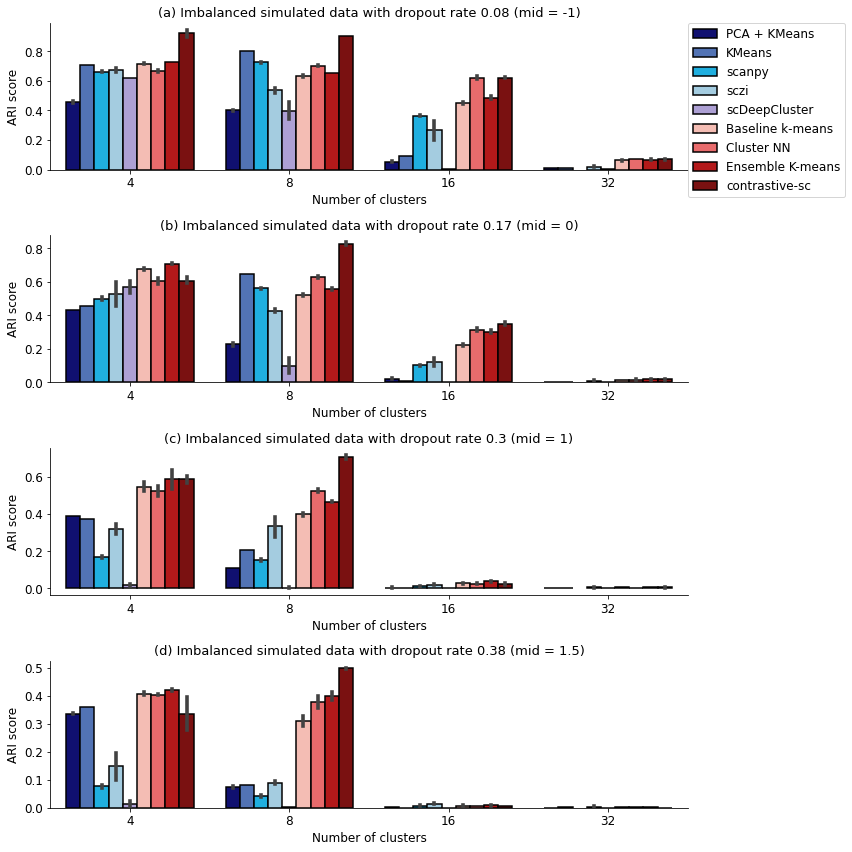

In [10]:
titles = ["(a)", "(b)", "(c)", "(d)",]
clrs = [
    'navy',
    '#416ec5',
    'deepskyblue',
    '#9acfea',
    "#a897dd",
    '#feb6aa',
    '#fd5658',
    '#cc0001',
    "darkred"
]
plt.figure(figsize=(12, 12))
for i, dropout_value in enumerate(sorted(all_df["dp"].unique())):
    df1 = all_df[all_df["dp"] == dropout_value].sort_values(by="nclust")
    df1.drop(["run", "dropout"], axis=1, inplace=True)
    df1 = pd.melt(df1, id_vars=['dataset', 'dp', 'nclust'])


    df1["variable"] = df1["variable"].apply(lambda x: utils.rename_column(x, "sota"))
    df1["order"] = df1["variable"].apply(utils.order_column)
    df1 = df1.sort_values(by="order", ascending=True)

    ax = plt.subplot(len(all_df["dp"].unique()), 1, i + 1)
    sns.barplot(data=df1,
                x="nclust",
                y="value",
                hue="variable",
                palette=clrs,
                edgecolor= 'black',
                linewidth=1.5,
                ax=ax)
    plt.xlabel("Number of clusters")
    plt.ylabel("ARI score")
    plt.title(f"{titles[i]} Imbalanced simulated data with dropout rate {dropout_value}" +
              f" (mid = {dropout_mid[dropout_value]})")
    if i ==0:
        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    else: 
        plt.legend([],[], frameon=False)
    sns.despine()
plt.tight_layout()
plt.savefig(f"{path}diagrams/imbalanced_by_dropout.pdf", bbox_inches='tight')

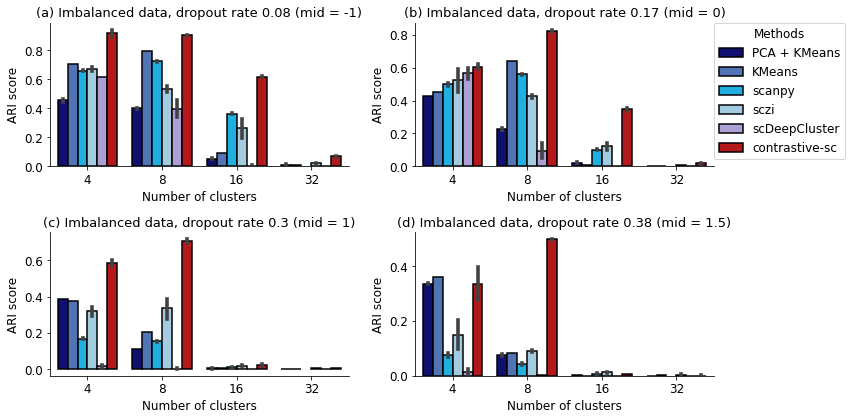

In [17]:
titles = ["(a)", "(b)", "(c)", "(d)",]
clrs = [
    'navy',
    '#416ec5',
    'deepskyblue',
    '#9acfea',
    "#a897dd",
    '#cc0001',
]
plt.figure(figsize=(12, 6))
for i, dropout_value in enumerate(sorted(all_df["dp"].unique())):
    df1 = all_df[all_df["dp"] == dropout_value].sort_values(by="nclust")
    df1.drop(["run", "dropout"], axis=1, inplace=True)
    df1 = pd.melt(df1, id_vars=['dataset', 'dp', 'nclust','method1_0', 'method1_1', 'method1_2',
       'method2_0', 'method2_1', 'method2_2', 'method3'])


    df1["variable"] = df1["variable"].apply(lambda x: utils.rename_column(x, "sota"))
    df1["order"] = df1["variable"].apply(utils.order_column)
    df1 = df1.sort_values(by="order", ascending=True)

    ax = plt.subplot(2, 2, i + 1)
    sns.barplot(data=df1,
                x="nclust",
                y="value",
                hue="variable",
                palette=clrs,
                edgecolor= 'black',
                linewidth=1.5,
                ax=ax)
    plt.xlabel("Number of clusters")
    plt.ylabel("ARI score")
    plt.title(f"{titles[i]} Imbalanced data, dropout rate {dropout_value}" +
              f" (mid = {dropout_mid[dropout_value]})")
    if i ==1:
        plt.legend(title = "Methods",bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    else: 
        plt.legend([],[], frameon=False)
    sns.despine()
plt.tight_layout()
plt.savefig(f"{path}diagrams/imbalanced_sota_by_dropout.pdf", bbox_inches='tight')

In [14]:
df1 = all_df.sort_values(by="nclust")
df1.drop(["run", "dropout"], axis = 1, inplace = True)

df1 =pd.melt(df1, id_vars=['dataset', 'dp',  'nclust'])
df1["variable"]=df1["variable"].apply(lambda x: utils.rename_column(x, "sota"))
df1["order"]=df1["variable"].apply(utils.order_column)
df1 = df1.sort_values(by ="order", ascending = True)

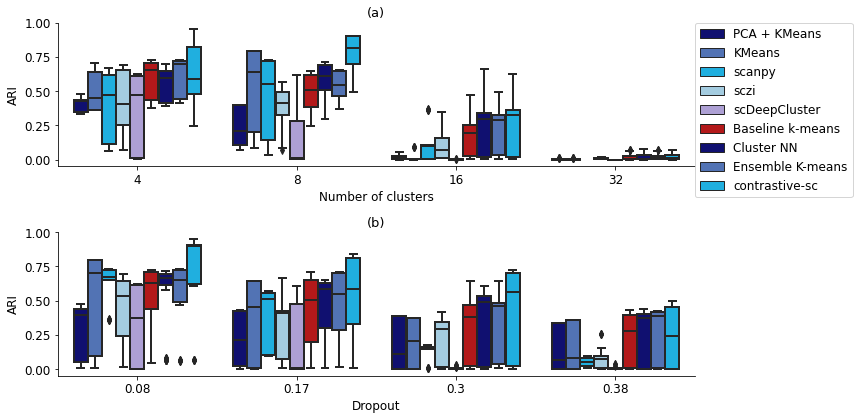

In [15]:
titles = ["(a)", "(b)", "(c)", "(d)",]
plt.figure(figsize=(12, 6))
ax = plt.subplot(211)
plt.title(titles[0])
sns.boxplot(x="nclust",
              y="value",
              hue="variable",
              palette=clrs,
              data=df1,
              ax=ax)
plt.xlabel("Number of clusters")
plt.ylabel("ARI")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.)
sns.despine()


ax = plt.subplot(212)
plt.title(titles[1])
sns.boxplot(
    x="dp",
    y="value",
    hue="variable",
    palette=clrs,
    data=df1.sort_values(by=["dp", "order"]),
    ax=ax)
plt.xlabel("Dropout")
plt.ylabel("ARI")
plt.legend([],[], frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(f"{path}diagrams/imbalanced_boxplot.pdf", bbox_inches='tight')

In [16]:
df1.to_pickle(f"{path}output/imbalanced.pkl")